In [96]:
import json
import os
import pprint
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import math
import numpy as np
import pandas as pd
import textwrap

import ipywidgets as widgets
from ipywidgets import HBox
from ipywidgets import interact, interact_manual
import IPython.display
from IPython.display import display, clear_output

#import plotly.graph_objects as go

class digest_query:
    def __init__(self, query_id, digest, digest_text, time_ms, cpu_usage, io, count, timestamp):
        self.query_id = query_id
        self.digest = digest
        self.digest_text = digest_text
        self.value = [[timestamp, time_ms, cpu_usage, io, count]]
        self.time_ms = []
        self.cpu_usage = []
        self.io = []
        self.count = []
        self.timestamp = []
    
    def add_time(self, time_ms):
        self.value[-1][1]+=time_ms
    
    def add_timestamp(self, time_ms, cpu_usage, io, count, timestamp):
        self.value.append([timestamp, time_ms, cpu_usage, io, count])
    
    def print_digest_query(self):
        print(f'query_id={self.query_id}')
        print(f'digest={self.digest}')
        print(f'digest_text={self.digest_text}')
        print(f'time_ms={self.time_ms}')
        print(f'cpu_usage={self.cpu_usage}')
    
    def sort_timestamp(self):
        self.value = list(map(lambda x: [x[0], float(x[1]), float(x[2]), int(x[3]), int(x[4])], self.value))
        self.value = sorted(self.value, key=lambda x:x[0])
        for v in self.value:
            self.time_ms.append(v[1]) 
            self.cpu_usage.append(v[2])
            self.timestamp.append(v[0])
            self.count.append(v[4])
            self.io.append(v[3])
        #new_count = list(np.diff(np.array(self.count)))
        #new_count.insert(0, 0)
        #print(new_count)
    
    def add_missing_value(self, all_timestamp):
        new_time_ms = []
        new_cpu_usage = []
        new_count = []
        new_io = []
        #print(all_timestamp)
        #print(self.timestamp)
        for time in all_timestamp:
            if time in self.timestamp: #b에서 val의 index
                new_time_ms.append(self.time_ms[self.timestamp.index(time)])
                new_cpu_usage.append(self.cpu_usage[self.timestamp.index(time)])
                new_count.append(self.count[self.timestamp.index(time)])
                new_io.append(self.io[self.timestamp.index(time)])
            else:
                new_time_ms.append(0)
                new_cpu_usage.append(0)
                new_count.append(0)
                new_io.append(0)
        #print(len(all_timestamp), len(new_time_ms), len(new_cpu_usage))
        self.time_ms = new_time_ms
        self.cpu_usage = new_cpu_usage
        self.count = new_count
        self.io = new_io


def import_data(path):
    dict = {}
    query_num = 0
    all_timestamp =[]

    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r') as f:
            # 같은 파일 내를 탐색
            file_datetime = dt.datetime.strptime(filename,'%Y%m%d_%H%M%S') 
            all_timestamp.append(file_datetime)
            text = json.load(f)
            #io = text['metrics_data']["global"]["engine"]["innodb_status_io"]
            performance_schema = text['metrics_data']['global']['performance_schema']
            threads = performance_schema['threads']       
            tid_dict = {i[0]['thread_id']:i[0]['thread_os_id'] for i in threads}
            cpu_usage = performance_schema['cpu_usage'] # thread_os_id : cpu_usage
            io = performance_schema['io'] 
            events_statements_history = performance_schema['events_statements_history'] # list of dict
            digest_list = []
            for event in events_statements_history:
                digest = event['digest']
                if digest is None:
                    continue
                #print(type(digest))
                thread_id = event['thread_id']
                digest_text = event['digest_text']
                count = event['count']
                time = event['time_ms']
                if digest in digest_list: # 같은 쿼리가 같은 시간대에 이미 존재할 경우? time만 합친다.
                    dict[digest].add_time(time)
                elif digest in dict.keys():
                    if str(tid_dict[thread_id]) in io.keys():
                        dict[digest].add_timestamp(time, cpu_usage[str(tid_dict[thread_id])], io[str(tid_dict[thread_id])], count, file_datetime)
                    else:
                        dict[digest].add_timestamp(time, cpu_usage[str(tid_dict[thread_id])], 0, count, file_datetime)
                else:
                    if str(tid_dict[thread_id]) in io.keys():
                        temp = digest_query(query_num, digest, digest_text, time, cpu_usage[str(tid_dict[thread_id])], io[str(tid_dict[thread_id])], count, file_datetime)
                    else:
                        temp = digest_query(query_num, digest, digest_text, time, cpu_usage[str(tid_dict[thread_id])], 0, count, file_datetime)
                    #key error 발생
                    dict[digest] = temp
                    query_num+=1
                digest_list.append(digest)
    all_timestamp.sort()
    return dict, all_timestamp
path = "data"
dict, all_timestamp = import_data(path)

def preprocess(dict):
    for query in dict:
        query_id = dict[query].query_id
        dict[query].sort_timestamp()
    return dict

dict = preprocess(dict)


def rank(dict, type, num):
    def Average(lst):
        return sum(lst) / len(lst)
    rank_list = []
    dict_by_id={}
    for query in dict:
        query_id = dict[query].query_id
        dict_by_id[query_id] = dict[query]
        rank_list.append((dict[query].query_id, Average(dict[query].time_ms), Average(dict[query].cpu_usage), Average(dict[query].io), Average(dict[query].count)))
        #print(dict[query].time_ms)
        dict[query].add_missing_value(all_timestamp)
        #print(dict[query].time_ms)
    
    if type == 'CPU':
        cpu_top = sorted(rank_list, key=lambda x:-x[2])[:num]
        cpu_top_qid = [i[0] for i in cpu_top]
        return cpu_top_qid
    elif type == 'Duration':
        time_top = sorted(rank_list, key=lambda x:-x[1])[:num]
        time_top_qid = [i[0] for i in time_top]
        return time_top_qid
    elif type == 'Disk IO':
        disk_top = sorted(rank_list, key=lambda x:-x[3])[:num]
        disk_top_qid = [i[0] for i in disk_top]
        return disk_top_qid
    elif type == 'Execution Count':
        count_top = sorted(rank_list, key=lambda x:-x[4])[:num]
        count_top_qid = [i[0] for i in count_top]
        return count_top_qid

In [166]:
#fig, ax = plt.subplots(figsize=(10, 7))
y1_max=0
y2_max=0
import mplcursors


def visualize(type, num, time_range):
    if type == 'CPU':
        fig = plt.figure(1)
        cpu_top_qid = rank(dict, 'CPU', num)
        for query in dict:
            if dict[query].query_id in cpu_top_qid:
                x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
                y = np.array(dict[query].cpu_usage, dtype=np.float64)
                plt.plot_date(x, y, xdate = True, ls = '-',label=str(dict[query].query_id) + " "+ dict[query].digest_text[:20])#, bottom = bottom1)
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title(f"CPU usage per query\nfor queries with top {num} CPU usage", size=20, fontweight="bold")

    elif type == 'Duration':
        fig = plt.figure(2)
        time_top_qid = rank(dict,'Duration', num)
        for query in dict:
            if dict[query].query_id in time_top_qid:
                x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
                y = np.array(dict[query].time_ms, dtype=np.float64)
                plt.plot_date(x, y, xdate = True, ls = '-', label=str(dict[query].query_id)+ " " + dict[query].digest_text[:20])#, bottom = bottom2)
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title(f"Query latency\nfor top {num} slowest queries", size=20, fontweight="bold")

    
    elif type == 'Disk IO':
        fig = plt.figure(3)
        disk_top_qid = rank(dict,'Disk IO', num)
        for query in dict:
            if dict[query].query_id in disk_top_qid:
                x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
                y = np.array(dict[query].io, dtype=np.float64)
                plt.plot_date(x, y, xdate = True, ls = '-', label=str(dict[query].query_id)+ " " + dict[query].digest_text[:20])#, bottom = bottom2)
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title(f"Disk IO per query\nfor queries with top {num} Disk IO", size=20, fontweight="bold")


    elif type == 'Execution Count':
        fig = plt.figure(4)
        count_top_qid = rank(dict,'Execution Count', num)
        for query in dict:
            if dict[query].query_id in count_top_qid:
                x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
                y = np.array(dict[query].count, dtype=np.float64)
                plt.plot_date(x, y, xdate = True, ls = '-', label=str(dict[query].query_id)+ " " + dict[query].digest_text[:20])#, bottom = bottom2)
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title(f"Execution Count for queries\nwith top {num} execution count", size=20, fontweight="bold")
    plt.xlim(x[-1]-time_range,x[-1])
    fig.autofmt_xdate()
    mplcursors.cursor()
    plt.tight_layout()
    plt.show()

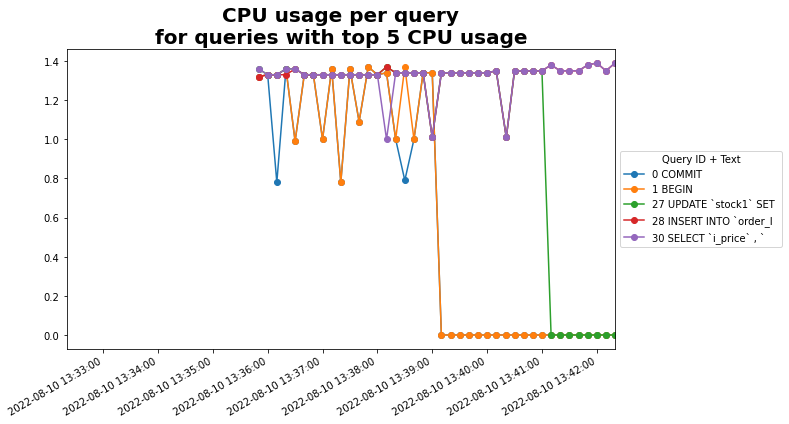

In [169]:
%matplotlib inline
#%matplotlib notebook
style = {'description_width': 'initial'}
layout = widgets.Layout(display='flex',
                align_items='center',
                width='50%')
w1 = widgets.Dropdown(
    options=['CPU', 'Disk IO', 'Duration', 'Execution Count'],
    value='CPU',
    description='Metric type:',
    style = style,
    layout = layout,
)
w2 = widgets.Dropdown(
    options=['Last 1 min', 'Last 10 min','Last 1 hr', 'Last 6 hrs', 'Last 24 hrs', 'past week', 'past month', 'custom'],
    value='Last 10 min',
    description='Time Period:',
    style = style,
    layout = layout,
)
w3 = widgets.Dropdown(
    options=['5','10','15'],
    value='5',
    description='# of queries:',
    style = style,
    layout = layout,
)

button = widgets.Button(description='Draw')

def on_click_callback(clicked_button: widgets.Button) -> None:
    """버튼이 눌렸을 때 동작하는 이벤트 핸들러"""
    num= int(w3.value)
    if w2.value == 'Last 1 min':
        time_range = dt.timedelta(minutes = 1)
    elif w2.value == 'Last 10 min':
        time_range = dt.timedelta(minutes = 10)
    elif w2.value == 'Last 1 hr':
        time_range = dt.timedelta(hours = 1)
    clear_output(wait = True)
    display(HBox(widget_list))
    visualize(w1.value, num, time_range)

plt.figure(1) # CPU
plt.figure(2) # Duration
plt.figure(3) # Disk IO
plt.figure(4) # Execution Count
clear_output(wait = True)
plt.rcParams['figure.figsize'] = [11, 6]
plt.rcParams["date.autoformatter.minute"] = "%Y-%m-%d %H:%M:%S"
plt.ion()

def on_change_w1(change):
    #clear_output(wait = True)
    if change['type'] == 'change' and change['name'] == 'value':
        if change['new'] == 'CPU' or change['new'] =='Duration' or change['new'] =='Disk IO' or change['new'] =='Execution Count':
            num= int(w3.value)
            if w2.value == 'Last 1 min':
                time_range = dt.timedelta(minutes = 1)
            elif w2.value == 'Last 10 min':
                time_range = dt.timedelta(minutes = 10)
            elif w2.value == 'Last 1 hr':
                time_range = dt.timedelta(hours = 1)
            clear_output(wait = True)
            display(HBox(widget_list))
            visualize(change['new'], num, time_range)
        else:
            print("not_implemented_yet")

            
#w1.observe(on_change_w1)
button.on_click(on_click_callback)
widget_list = [w1,w2,w3,button]

display(HBox(widget_list))

In [ ]:
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import math


fig, axs = plt.subplots(2, figsize=(10, 7))
y1_max=0
y2_max=0
bottom1 = np.zeros(len(all_timestamp))
bottom2 = np.zeros(len(all_timestamp))
def sumzip(*items):
    return [sum(values) for values in zip(*items)]

for query in dict:
    #dict[query].print_digest_query()
    if dict[query].query_id in cpu_top5_qid:
        x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
        y1 = np.array(dict[query].cpu_usage, dtype=np.float64)
        #y1_max = max(y1_max, max(y1))
        axs[0].bar(x, y1, width = 0.0001, label=str(dict[query].query_id) + " "+ dict[query].digest_text[:20], bottom = bottom1)
        print(dict[query].query_id)
        #print(x)
        #print(y1)
        bottom1 = y1 + bottom1


    if dict[query].query_id in time_top5_qid:
        qid=dict[query].query_id
        x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
        y2 = np.array(dict[query].time_ms, dtype=np.float64)
        print(dict[query].query_id)
        #print(x)
        #print(y2)
        
        axs[1].bar(x, y2, width = 0.0001, label=str(dict[query].query_id)+ " " + dict[query].digest_text[:20], bottom = bottom2)
        #y2_max = max(y2_max, max(y2))
        bottom2 = y2 + bottom2
    


axs[0].set_yticks(np.linspace(0,max(bottom1),10))
axs[0].legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
axs[0].set_title("CPU usage per query for queries with top 5 CPU usage")
axs[1].set_yticks(np.linspace(0,max(bottom2),10))
axs[1].legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
axs[1].set_title("Query latency for top 5 slowest queries")


plt.tight_layout()

#plt.legend()
plt.show()


In [ ]:
list1 = dict_by_id[44].time_ms

list2 = [(list1[i]+list1[i+1])/2 for i in range(len(list1)) if i%2==0 and len(list1)>i+1] # 2배로 rollup
print(list1)
print(list2)
print(len(list1), len(list2))

list4 = [(list2[i]+list2[i+1])/2 for i in range(len(list2)) if i%2==0 and len(list2)>i+1] # 4배로 rollup

print(list4)
print(len(list4))

# n배 rollup하는법
# x by n 으로 reshape한다
# 1234
# 5678 2 by 4
# 행을 평균낸다?


In [ ]:
#easy rollup

a = np.arange(13)
p = 5
a = np.append(a,np.zeros(p-len(a)%p))

a=a.reshape(p,int(len(a)/p))
a.mean(axis=1)

In [ ]:
import subprocess

# proc = subprocess.Popen(
#     ['ps -ef | grep mysql'],
#     stdout=subprocess.PIPE
#     )
# out, err = proc.communicate()
# print(out)
# print(out.decode('utf-8'))

ps_result = subprocess.check_output(['ps -ef | grep mysql'], shell=True).decode()


ps_lines = ps_result.splitlines()
TID = []
for ps_line in ps_lines:
    ps_line=ps_line.replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ')
    ps = ps_line.split(' ')
    if 'mysql' in ps[0]:
        TID.append(ps[1])

print(TID)
# result = subprocess.check_output(['pidstat', '-t']).decode()
# #len (result.splitlines()) 
# result.splitlines()
# lines = result.splitlines()[3:]
# dict={}
# for line in lines:
#     line=line.replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ')
#     words = line.split(' ')
#     # TID = words[3]
#     # %cpu = words[8]
#     if words[3] =='-':
#         continue
#     dict[words[3]] = words[8]

# sorted(dict.items(),key=lambda x:x[1],reverse=True)


In [ ]:
# Interactive Mode

%matplotlib notebook

# Import Library


import numpy as np
import time
import matplotlib.pyplot as plt

# Create subplots

figure, ax = plt.subplots(figsize=(4,5))

# Data Coordinates

x = np.linspace(0, 20, 80)
y = np.sin(x)

# GUI

plt.ion()

#  Plot

plot1, = ax.plot(x, y)

# Labels

plt.xlabel("X-Axis",fontsize=18)
plt.ylabel("Y-Axis",fontsize=18)

for value in range(150):
    update_y_value = np.sin(x-2.5*value)
    
    plot1.set_xdata(x)
    plot1.set_ydata(update_y_value)
    
    figure.canvas.draw()
    figure.canvas.flush_events()
    time.sleep(0.1)


# Display

#plt.show()